# **Chatbot with message summarization & external DB**

**Review**

We've covered how to customize graph state schema and reducer.

We've also shown a number of tricks for trimming or filtering messages in graph state.

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

**Goals**

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases.

Here, we'll show how to use Sqlite as a checkpointer, but other checkpointers, such as Postgres are available!

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_google_genai

In [2]:
import os
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"]=GOOGLE_API_KEY

## **SQLite**

A good starting point here is the SqliteSaver checkpointer.

Sqlite is a small, fast, highly popular SQL database.

If we supply **":memory:"** it creates an in-memory Sqlite database.

In [3]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

But, if we supply a db path, then it will create a database for us!

In [4]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

--2025-02-20 08:08:37--  https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db [following]
--2025-02-20 08:08:37--  https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110592 (108K) [application/octet-stream]
Saving to: ‘state_db/example.db’

example.db          100%[===================>] 108.00K  --.-KB/s    in 0.02s   

2025-02-20 08:08:38 (4.46 MB/s) - ‘s

In [5]:
# Here is our checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

## **Chatbot**

In [11]:
from langgraph.graph import START, END, StateGraph
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

In [8]:
from langchain_google_genai import ChatGoogleGenerativeAI
# Loading Model
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [7]:
# Defining state
class State(MessagesState):
  summary: str

In [12]:
# call model node
def call_model(state: MessagesState) -> State:
  # Get the summary
  summary = state.get("summary", "")
  if summary:
    # Add summary to system message
    sys_message = f"Summary of conversation earlier: {summary}"
    messages = [SystemMessage(content=sys_message) + HumanMessage(content=state["messages"])]
  else:
    messages = state["messages"]
  response = model.invoke(messages)
  return {"messages": response}

# summarize conversation node
def summarize_conversation(state: MessagesState) -> State:
  # Get the summary
  summary = state.get("summary", "")
  if summary:
    summary_message = (
        f"This is summary of the conversation to date: {summary}\n\n"
        "Extend the summary by taking into account the new messages above:"
    )
  else:
    summary_message = "Create the summary of the conversation above:"

  # Add prompt to history
  messages = state["messages"] + [HumanMessage(content=summary_message)]
  response = model.invoke(messages)

  # Delete messages except 2 most recent
  deleted_messages = [RemoveMessage(msg.id) for msg in state["messages"][:-2]]
  return {"summary": response.content, "messages": deleted_messages}

In [13]:
from typing import Literal
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal["summarize_conversation", END]:
  """Returns the next node to execute"""
  messages = state["messages"]
  # If there are more than six messages, then we summarize the conversation
  if len(messages) > 6:
      return "summarize_conversation"
  return END

Now, we just re-compile with our sqlite checkpointer.

In [14]:
# Workflow
workflow = StateGraph(MessagesState)

# Add Node
workflow.add_node("call_model", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

# Add Edge
workflow.add_edge(START, "call_model")
workflow.add_conditional_edges("call_model", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)

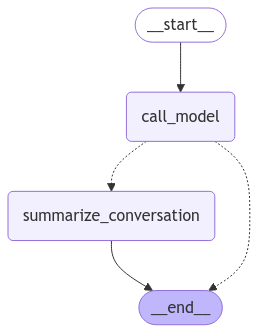

In [15]:
# Visualize
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times.

In [16]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

In [20]:
# By default our DB have conversation for thread 1
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='086e80ce-8bd0-4dee-b13c-f47160d6755f'), AIMessage(content="Hello Lance! You've already introduced yourself, but it's nice to greet you again. Is there something specific you'd like to talk about? Perhaps you'd like to continue our conversation about the 49ers, or is there another topic you're interested in discussing?", additional_kwargs={}, response_metadata={'id': 'msg_01AkDF6AH7LMp2YDDD9jQkEC', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 197, 'output_tokens': 58}}, id='run-7f8af5e1-5248-4ccd-ab46-87580422f0d6-0', usage_metadata={'input_tokens': 197, 'output_tokens': 58, 'total_tokens': 255}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='e33f42ee-cdb0-45ec-b100-54dcd4c82e71'), AIMessage(content="Your name is Lance. You've introduced yourself twice durin

In [21]:
# Create another thread
config = {"configurable": {"thread_id": "2"}}

In [22]:
graph.get_state(config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '2'}}, metadata=None, created_at=None, parent_config=None, tasks=())

In [23]:
# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Lance! It's nice to meet you. How can I help you today?
================================== Ai Message ==================================

Your name is Lance. You just told me! 😊
================================== Ai Message ==================================

That's awesome! They're a great team. What's your favorite thing about the 49ers? Are you excited for the upcoming season?


In [24]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='31312bbe-fcf1-433f-9b3c-2b595b03af67'), AIMessage(content="Hi Lance! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d76b1059-bd4f-440d-bb3f-88222c231937-0', usage_metadata={'input_tokens': 6, 'output_tokens': 19, 'total_tokens': 25, 'input_token_details': {'cache_read': 0}}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='808d0827-ac86-4fb4-8ced-4c3cad797987'), AIMessage(content='Your name is Lance. You just told me! 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-819c0299-3820-47a3-aece-fe5783620d0e-0', usage_metadata={'input_tokens': 30, 'output_tokens

## **Persisting State**

Using database like Sqlite means state is persisted!

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.

In [25]:
# Create a thread
config = {"configurable": {"thread_id": "2"}}
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='31312bbe-fcf1-433f-9b3c-2b595b03af67'), AIMessage(content="Hi Lance! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d76b1059-bd4f-440d-bb3f-88222c231937-0', usage_metadata={'input_tokens': 6, 'output_tokens': 19, 'total_tokens': 25, 'input_token_details': {'cache_read': 0}}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='808d0827-ac86-4fb4-8ced-4c3cad797987'), AIMessage(content='Your name is Lance. You just told me! 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-819c0299-3820-47a3-aece-fe5783620d0e-0', usage_metadata={'input_tokens': 30, 'output_tokens